In [1]:
from Bio import Entrez
import xmltodict
import yaml
from pymongo import MongoClient
import warnings
import pandas as pd
from pprint import pprint
import re
from linkml.utils.schemaloader import SchemaLoader
from linkml_runtime.dumpers import yaml_dumper
import uuid
import math
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt

# Setup

`pip install -r requirements_issue_375.txt`

- Copy `config/nmdc_mongo_db_template.yaml` to `config/nmdc_mongo_db.yaml` and replace the `<SECRET>`s with the host address and your password for the NMDC mongodb server.

```
mongo_nmdc_password:
  "<SECRET>"
mongo_nmdc_host:
  "<SECRET>"
```

- Clone the nmdc-schema GitHub repo from git@github.com:microbiomedata/nmdc-schema.git
- Change the location of `local_nmdc_linkml_file` if necessary below
- Clone the mixs-source GitHub repo from git@github.com:cmungall/mixs-source.git
- Change the location of `local_mixs_linkml_file` if necessary below


# Notes

See also
- https://github.com/microbiomedata/nmdc-metadata/issues/375
- https://docs.google.com/spreadsheets/d/1GZayIFIrY2jdoxRIpk9KDTBLiE71VVtb7YAd5ZSYGR0/edit#gid=0

Did CJM say that `samp_collec_device` has the range of ontology term? 

```
name: samp_collec_device
...
range: string
...
description: The device used to collect an environmental sample. This field accepts
  terms listed under environmental sampling device (http://purl.obolibrary.org/obo/ENVO).
  This field also accepts terms listed under specimen collection device (http://purl.obolibrary.org/obo/GENEPIO_0002094).
```

When opening Excel spreadsheets:

> /Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
  
Addressed with https://docs.python.org/3/library/warnings.html

Still getting some `value is trying to be set on a copy of a slice` warnings

Still getting some `Unrecognized prefix` warnings on `SchemaLoader()`

Slots available for https://cmungall.github.io/mixs-source/QuantityValue/: 

- `has_raw_value`
- `has unit`

and 

```
➞has numeric value OPT
range: Double
```

Need to process `EnvironmentalMetadata` tab

No plant associated data in the example template yet, no parsing example. Should follow established patterns

```
13	plant_associated	host_common_name
14	plant_associated	host_taxid
11	plant_associated	plant_struc
```


Is bmt useful for winnowing down the relevant MIxS slots?

In [2]:
# import bmt

# tk = bmt.Toolkit("../../nmdc-schema/src/schema/nmdc.yaml")

# attrib_descendants = tk.get_descendants(name='attribute')
# attrib_descendants.sort()

# print(len(attrib_descendants))

# attrib_descendants

# # 614 out of the 699 slots in mixs are descendants of 'attribute'
##  filtering doens't seem worth it here

# Provenance



saved https://docs.google.com/spreadsheets/d/1GZayIFIrY2jdoxRIpk9KDTBLiE71VVtb7YAd5ZSYGR0/edit#gid=0
to `input/Example-Soil_NMDC_SampleMetadata.xlsx` on 2021-07-13

Also 
- `Example-Soil_NMDC_SampleMetadata_20210802.xlsx`
- `Example-Soil_NMDC_SampleMetadata_202107201146.xlsx`


The "Metadata" sheet in the NMDC Sample Metadata template has four header rows and color coded blocks of columns. The green and red sections have fixed columns. Here, the second though fourth rows provide elaboration on the expected content. _Remember, Pandas interprets the very first row as a dataframe's headers by default._


In [3]:
template_file = "../input/Example-Soil_NMDC_SampleMetadata_20210802.xlsx"
header_rows = 4

# column/color block realtions for `Metadata` tab
# "Sample Identification"
green_id_col = ["ID"]
additional_green_col_names = [
    "sample_name",
    "investigation_type",
    "package",
    "source_mat_ID",
]
green_cols = green_id_col + additional_green_col_names

# "Required for all samples"
red_col_names = [
    "growth_facil",
    "geo_loc_name",
    "lat_lon",
    "collection_date",
    "samp_mat_process",
    "store_cond",
    "samp_store_temp",
    "samp_size",
    "env_broad_scale",
    "env_local_scale",
    "env_medium",
    "gold_ecosystem",
    "microbiome_taxonomy",
]

In [4]:
local_nmdc_linkml_file = "../../nmdc-schema/src/schema/nmdc.yaml"
local_mixs_linkml_file = "../../mixs-source/model/schema/mixs.yaml"

# Donny suggested some other way of conencting to mongodb
mongodb_conf_file = "../config/nmdc_mongo_db.yaml"
mongodb_user = "mam"
mongodb_host = "mongo-ext.nmdc-runtime-dev.polyneme.xyz"

# could use entrez to retrieve addtional project details based on NCBI IDs
# initialize some default parameters
Entrez.email = "MAM@lbl.gov"  # provide your email address
paramEutils = {"usehistory": "Y"}  # Use Entrez search history to cache results

# mixs_spreadsheet_url = "https://github.com/GenomicsStandardsConsortium/mixs-legacy/blob/master/mixs5/mixs_v5.xlsx?raw=true"
# # could also get MIxS knoweldge from NMDC schema... have been menaing to parse that anyway
# # CJM encourages use of his MiXS 6 yaml file (local_mixs_linkml_file)

In [5]:
with open(mongodb_conf_file) as conf_file:
    conf_data = yaml.load(conf_file, Loader=yaml.Loader)

In [6]:
# mongodb://[username:password@]host1[:port1][,...hostN[:portN]][/[defaultauthdb][?options]]
# mongo_conn_str = "mongodb://localhost"

mongo_conn_str = (
    "mongodb://"
    + mongodb_user
    + ":"
    + conf_data["mongo_nmdc_password"]
    + "@"
    + conf_data["mongo_nmdc_host"]
)


client = MongoClient(mongo_conn_str)

In [7]:
def remove_nans_from_dict(inp_dict):
    clean_dict = {k: v for k, v in inp_dict.items() if v == v}
    return clean_dict

In [8]:
def merge_j_on_index(left_j, right_j):
    left_copy = left_j.copy()
    for i in range(len(green_nmdc)):
        left_copy[i] = remove_nans_from_dict(left_copy[i])
        right_temp = right_j[i]
        right_temp = remove_nans_from_dict(right_temp)
        left_copy[i].update(right_temp)
    return left_copy

In [9]:
# should we check that each ID is only used once in each dict?
def merge_j_on_id(left_j, right_j):
    # the zipping and unzipping will be repeated unneccessarily?
    left_ids = [a_dict["id"] for a_dict in left_j]
    left_zip = dict(zip(left_ids, left_j))
    right_ids = [a_dict["id"] for a_dict in right_j]
    right_zip = dict(zip(right_ids, right_j))
    shared_ids = set(left_ids).intersection(set(right_ids))
    for i in shared_ids:
        # this will get repeated each time this function is called. refactor?
        left_zip[i] = remove_nans_from_dict(left_zip[i])
        right_zip[i] = remove_nans_from_dict(right_zip[i])
        left_zip[i].update(right_zip[i])
    # unzip
    left_values_only = list(left_zip.values())
    return left_values_only

In [10]:
def make_searchable_sheet(df):
    zipped_tmts = dict(zip(df.columns, range(len(df.columns))))
    searchable = df.rename(columns=zipped_tmts).stack()
    return searchable


def search_get_coords(searchable, search_string):
    match_coords_list = searchable[(searchable == search_string)].index.tolist()
    return match_coords_list


def euc_pair_dist(point1, point2):
    x_dist = point2[0] - point1[0]
    xds = x_dist ** 2
    y_dist = point2[1] - point1[1]
    yds = y_dist ** 2
    dist_sum = xds + yds
    dist_root = math.sqrt(dist_sum)
    return dist_root


def find_first_closest(xy_tuple_list, origin):
    dists = []
    for xy_tuple in xy_tuple_list:
        current_dist = euc_pair_dist(origin, xy_tuple)
        dists.append(current_dist)
    val, idx = min((val, idx) for (idx, val) in enumerate(dists))
    return xy_tuple_list[idx]


def get_from_find_to_end(df, start, colcount):
    df_row_count = len(df.index)
    found_to_end = df.iloc[
        start[0] : (df_row_count - 1), start[1] : (start[1] + (colcount))
    ]
    found_to_end = found_to_end.reset_index(drop=True)
    return found_to_end


# assuming we should search for nas in first column
def get_from_start_to_na(df):
    df_isna = df.isna()
    df_isna_loc = df_isna.idxmax().values[0]
    # could this ever be larger than one element?
    df_to_na = df[0:df_isna_loc]
    return df_to_na


def colnames_from_rowvals(df, row):
    df.columns = df.iloc[row].values
    return df


def colnames_from_rowvals(df, row):
    df.columns = df.iloc[row].values
    return df

In [11]:
def remove_rows_matching_list(
    df, column, exclusion_list, remove_nans=True, remove_header_val=True
):
    if remove_header_val:
        col_header = df.columns[column]
        exclusion_list.append(col_header)
    extract = df.iloc[:, column]
    goodflag = ~extract.isin(exclusion_list)
    keepers = df[goodflag]
    if remove_nans:
        keepers.dropna(axis=0, how="any", inplace=True)
    keepers.reset_index(drop=True, inplace=True)
    return keepers

In [12]:
def get_optics_coord_frame(df, current_search_string):
    # may have already been assembled elsewhere ... factor back out?
    searchable_menu = make_searchable_sheet(df)
    tx_coords = search_get_coords(searchable_menu, current_search_string)
    tx_coord_frame = pd.DataFrame(tx_coords, columns=["y", "x"])
    tx_custers = OPTICS(min_samples=2).fit(tx_coords)
    tx_per_coord_labels = tx_custers.labels_
    tx_coord_frame["cluster"] = tx_per_coord_labels
    return tx_coord_frame

In [13]:
cluster_colors = {
    -1: "gray",
    0: "red",
    1: "black",
    2: "green",
    3: "orange",
    4: "purple",
    5: "brown",
}

### `get_optics_coord_frame`

- Shouldn't assume that there will be one largest cluster
- Shouldn't assume number of clusters/cluster_colors
- These cluster_colors don't have anything to do with the color blocks int the Metadata tab

In [14]:
def get_data_from_extended_cluster_coords(
    data_df, cluster_coords_df, largest_index, additional_columns=0
):
    temp = cluster_coords_df[cluster_coords_df["cluster"] == largest_index]
    xmin = temp["x"].min()
    xmax = temp["x"].max()
    ymin = temp["y"].min()
    ymax = temp["y"].max()

    additional_columns = 3
    extended_x_max = xmax + additional_columns
    data_from_extended_cluster_coords = data_df.loc[ymin:ymax, xmin:extended_x_max]
    return data_from_extended_cluster_coords

In [15]:
def pivot_multi_columns(colname_base):
    temp_match_cols = [col for col in blue_cols if re.search(r"^" + colname_base, col)]
    temp_cols = green_id_col + temp_match_cols
    temp_content = blue_content[temp_cols]
    temp_content_piv = pd.melt(temp_content, id_vars="ID")
    temp_content_piv
    nan_flag = temp_content_piv["value"].isna()
    temp_content_piv = temp_content_piv[~nan_flag]
    temp_headers = blue_headers[temp_match_cols]
    temp_headers = temp_headers.iloc[0:1, :]
    temp_headers_piv = pd.melt(temp_headers)
    temp_piv_merged = temp_content_piv.merge(
        right=temp_headers_piv, how="left", left_on="variable", right_on="variable"
    )
    return temp_piv_merged

In [16]:
def concatenate_melted_multi(
    melted_multi_df,
    data_col_name,
    source_id_col_name="ID",
    x_drop="value_x",
    y_drop="value_y",
):
    temp_multi = melted_multi_df
    cols_for_concat = [x_drop, y_drop]
    temp_multi[data_col_name] = melted_multi_df[cols_for_concat].apply(
        lambda row: " ".join(row.values.astype(str)), axis=1
    )
    temp_multi = temp_multi.drop([x_drop, y_drop], axis=1)
    temp_multi_pivot = temp_multi.pivot(
        index=source_id_col_name, columns="variable", values=data_col_name
    )
    temp_multi_pivot["id"] = temp_multi_pivot.index
    temp_multi_pivot = temp_multi_pivot.reset_index(drop=True)
    return temp_multi_pivot

In [17]:
def rename_melted_multi(
    melted_multi_df,
    source_id_col_name="ID",
    x_drop="value_x",
    y_drop="value_y",
):
    temp_recon = melted_multi_df.pivot(
        index=source_id_col_name, columns=y_drop, values=x_drop
    )
    temp_recon["id"] = temp_recon.index
    temp_recon = temp_recon.reset_index(drop=True)
    return temp_recon

In [18]:
warnings.filterwarnings("ignore", category=UserWarning)

Should we want to double check anything with NCBI...

In [19]:
# list Entrez databases
entrez_databases = Entrez.read(Entrez.einfo())
entrez_databases

{'DbList': ['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'ncbisearch', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'biosystems', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']}

# List the tabs (sheets) in the NMDC Biosample Metadata Template

In [20]:
template_frame_structure = pd.read_excel(template_file, sheet_name=None)
template_sheet_names = template_frame_structure.keys()
list(template_sheet_names)

['ReadMe',
 'ProjectInformation',
 'AssociatedResearchers',
 'Metadata',
 'EnvironmentalMetadata',
 'EcosystemTerms',
 'MenuTerms']

# `ProjectInformation` tab

The project data are are organized in a single column

They correspond to MIxS `study` modeling

Transforming them here to a single-row dataframe, based on prior experience with metadata tab

In [21]:
template_projinf_frame = pd.read_excel(template_file, sheet_name="ProjectInformation")
template_projinf_frame = template_projinf_frame.transpose()
template_projinf_frame.columns = template_projinf_frame.iloc[0]
template_projinf_frame = template_projinf_frame.reset_index(drop=True)

# drop field names once they've become column names
template_projinf_frame = template_projinf_frame.drop(0)

# # drop blank left-most column
column_numbers = [
    x for x in range(template_projinf_frame.shape[1])
]  # list of columns' integer indices
column_numbers.remove(0)  # removing column integer index 0
template_projinf_frame = template_projinf_frame.iloc[
    :, column_numbers
]  # return all columns except the 0th column

template_projinf_frame

Study Metadata,Project/Study Name,Principal Investigator Name,Principal Investigator Email,Principal Investigator ORCiD,LinkOut Webpage,Project/Study Description,Associated Publications,Dataset DOIs,Type of samples,Alternative Names,EMSL Proposal/Study Number,GOLD Study ID,JGI Proposal ID,Umbrella Bio Project Name,Umbrella Bio Project ID
1,"""Soil microbial response to elevated temperatu...",Montana Smith,montana.smith@pnnl.gov,0000-0002-8683-0050,https://microbiomedata.org/ | https://github.c...,Northern latitude peatlands contain large rese...,https://doi.org/10.1016/j.soilbio.2019.107561 ...,https://doi.org/10.25585/1487765,soil,NaN,EMSL:29728,GOLD:Gs01971387,JGI:1781,NCBI Accession: PRJNA594403,NCBI ID: 594403


In [22]:
proj_row_list = template_projinf_frame.to_dict("records")
proj_row_list
proj_obj = proj_row_list[0]
pprint(proj_obj)

{'Alternative Names': nan,
 'Associated Publications': 'https://doi.org/10.1016/j.soilbio.2019.107561 | '
                            'Keiser, Ashley D., et al. "Peatland microbial '
                            'community response to altered climate tempered by '
                            'nutrient availability." Soil Biology and '
                            'Biochemistry 137 (2019): 107561.',
 'Dataset DOIs': 'https://doi.org/10.25585/1487765',
 'EMSL Proposal/Study Number': 'EMSL:29728',
 'GOLD Study ID': 'GOLD:Gs01971387',
 'JGI Proposal ID': 'JGI:1781',
 'LinkOut Webpage': 'https://microbiomedata.org/ | '
                    'https://github.com/microbiomedata',
 'Principal Investigator Email': 'montana.smith@pnnl.gov',
 'Principal Investigator Name': 'Montana Smith',
 'Principal Investigator ORCiD': '0000-0002-8683-0050',
 'Project/Study Description': 'Northern latitude peatlands contain large '
                              'reserves of soil carbon (C) due in part to '
        

## Example of obtaining project details from NCBI with Entrez

Reddy: no API for GOLD and JGI?
But the values may be in NCBI?
What about EMSL or

In [23]:
# value of having both BioProject ID and accession "name"?
proj_bioproj_id = proj_obj["Umbrella Bio Project ID"]
bioproj_rhs = re.sub("^.*: *", "", proj_bioproj_id)
# bioproj_rhs

In [24]:
handle = Entrez.esummary(db="bioproject", id=bioproj_rhs)
record = Entrez.read(handle)
handle.close()
# record

bioproj_record_json = json.dumps(record, indent=4, sort_keys=False, default=str)
# print(bioproj_record_json)

---

## Get NMDC classes

In [25]:
# nmdc_schema_resolved = load_raw_schema(local_nmdc_linkml_file)

nmdc_schema_resolved = SchemaLoader(local_nmdc_linkml_file).resolve()

nmdc_resolved_classes = list(nmdc_schema_resolved.classes.keys())
nmdc_resolved_classes.sort()

# nmdc_resolved_classes

Unrecognized prefix: rdfs
Unrecognized prefix: insdc.srs
Unrecognized prefix: mgnify
Unrecognized prefix: UniProtKB
Unrecognized prefix: gtpo
Unrecognized prefix: COG
Unrecognized prefix: MetaCyc
Unrecognized prefix: EC
Unrecognized prefix: MetaNetX
Unrecognized prefix: RetroRules


## Get NMDC schema `study` slots
_Included inherited slots_

This and more will all be reconciled below

In [26]:
study_slots = nmdc_schema_resolved.classes["study"].slots
study_slots.sort()
# study_slots

## Get `ProjectInformation` fields from `Example-Soil_NMDC_SampleMetadata`

Might have to use APIs like from Entrez to look up details for some of those IDs?

In [27]:
project_fields = list(template_projinf_frame.columns)
project_fields.sort()
# project_fields

## Get `study` data from mongodb

In [28]:
db = client.nmdc
coll = db["study_set"]

any_study = coll.find_one({"type": "nmdc:Study"})
pprint(any_study)

{'_id': ObjectId('60e840cbe9822b255ad93845'),
 'description': 'This study is part of the Plant-Microbe Interfaces Science '
                'Focus Area, which aims to gain a deeper understanding of the '
                'diversity and functioning of mutually beneficial interactions '
                'between plants and microbes in the rhizosphere. Ongoing '
                'efforts focus on characterizing and interpreting such '
                'interfaces using systems comprising plants and microbes, in '
                'particular the poplar tree (Populus) and its microbial '
                'community in the context of favorable plant microbe '
                'interactions.',
 'doi': {'has_raw_value': 'https://doi.org/10.25585/1488096'},
 'ecosystem': 'Host-associated',
 'ecosystem_category': 'Plants',
 'ecosystem_subtype': 'Unclassified',
 'ecosystem_type': 'Unclassified',
 'id': 'gold:Gs0103573',
 'name': 'Populus root and rhizosphere microbial communities from Tennessee, '
    

In [29]:
all_studies = list(coll.find({}))

study_frame = pd.DataFrame(all_studies)

study_frame

,_id,id,name,description,ecosystem,ecosystem_category,ecosystem_type,ecosystem_subtype,specific_ecosystem,principal_investigator,type,websites,title,doi,publications
0,60e840cbe9822b255ad93845,gold:Gs0103573,Populus root and rhizosphere microbial communi...,This study is part of the Plant-Microbe Interf...,Host-associated,Plants,Unclassified,Unclassified,Unclassified,{'has_raw_value': 'Dale Pelletier'},nmdc:Study,[https://pmiweb.ornl.gov/pmi-project-aims/],Defining the functional diversity of the Popul...,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.1128/mSystems.00045-18]
1,60e840cbe9822b255ad93846,gold:Gs0110138,"Peatland microbial communities from Minnesota,...",This study is part of the Spruce and Peatland ...,Environmental,Aquatic,Freshwater,Wetlands,Unclassified,{'has_raw_value': 'Erik Lilleskov'},nmdc:Study,[https://mnspruce.ornl.gov/project/overview],"Fungal, bacterial, and archaeal communities me...",{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
2,60e840cbe9822b255ad93847,gold:Gs0114663,Riverbed sediment microbial communities from t...,"This research project, led by James Stegen at ...",Environmental,Aquatic,Freshwater,River,Sediment,"{'has_raw_value': 'James Stegen', 'profile_ima...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.1371/journal.pone.0228165]
3,60e840cbe9822b255ad93848,gold:Gs0114675,Deep subsurface shale carbon reservoir microbi...,This project aims to improve the understanding...,Environmental,Terrestrial,Deep subsurface,Unclassified,Unclassified,"{'has_raw_value': 'Kelly Wrighton', 'profile_i...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
4,60e840cbe9822b255ad93849,gold:Gs0128850,Lab enrichment of tropical soil microbial comm...,This study is part of the Microbes Persist: Sy...,Environmental,Terrestrial,Soil,Unclassified,Forest Soil,"{'has_raw_value': 'Jennifer Pett-Ridge', 'prof...",nmdc:Study,[https://sc-programs.llnl.gov/biological-and-e...,Microbial Carbon Transformations in Wet Tropic...,{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
5,60e840cbe9822b255ad9384a,gold:Gs0135149,Bulk soil microbial communities from the East ...,This research project aimed to understand how ...,Environmental,Terrestrial,Soil,Meadow,Bulk soil,"{'has_raw_value': 'Eoin Brodie', 'profile_imag...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.21952/WTR/1573029]
6,60e840cbe9822b255ad9384c,gold:Gs0154044,Bulk and rhizosphere soil microbial communitie...,The goal of this Bio-Scales Pilot Project stud...,Environmental,Terrestrial,Soil,Unclassified,Unclassified,"{'has_raw_value': 'Mitchel J. Doktycz', 'profi...",nmdc:Study,[https://www.ornl.gov/staff-profile/mitchel-j-...,Bio-Scales: Defining plant gene function and i...,{'has_raw_value': 'https://doi.org/10.46936/10...,NaN


In [30]:
study_cols = list(study_frame.columns)
study_cols.sort()
study_cols

['_id',
 'description',
 'doi',
 'ecosystem',
 'ecosystem_category',
 'ecosystem_subtype',
 'ecosystem_type',
 'id',
 'name',
 'principal_investigator',
 'publications',
 'specific_ecosystem',
 'title',
 'type',
 'websites']

In [31]:
study_frame.isna().sum()

_id                       0
id                        0
name                      0
description               0
ecosystem                 0
ecosystem_category        0
ecosystem_type            0
ecosystem_subtype         0
specific_ecosystem        0
principal_investigator    0
type                      0
websites                  3
title                     3
doi                       0
publications              4
dtype: int64

## Curated matches between schema and template

| NMDC schema study slots  | ProjectInformation fields from Example-Soil_NMDC_SampleMetadata   |
|:-------------------------|:------------------------------------------------------------------|
| alternative names        | Alternative Names                                                 |
| description              | Project/Study Description                                         |
| doi                      | Dataset DOIs                                                      |
| title                    | Project/Study Name                                                |
| principal investigator   | Principal Investigator ORCiD, Principal Investigator ORCiD        |
| publications             | Associated Publications                                           |
| type                     | constant 'study'                                                  |
| websites                 | LinkOut Webpage                                                   |


## How many of these ID-like columns do we expect to be populated? 

0? 1? Multiple? All?

**How to prioritize picking just one?**

Putting all of them in `alternate identifiers` for the time being

- GOLD Study ID
    - CJM says prioritize this.
    - Then what?
- EMSL Proposal/Study Number
- JGI Proposal ID
- Umbrella Bio Project ID
    - what is the relation between this and the bioproject accession?

<!-- **Prioritizing GOLD. Need additional rules.** -->

## Mongodb utilized but unaccounted-for slots
Ie. these slots are defined in the NMDC schema and have at least some data in the current mongodb. However, there don't seem to be any corresponding ProjectInformation columns in the template 

- id (see above)
- All study-wide ecosystem terms
    - ecosystem
    - ecosystem_category
    - ecosystem_subtype
    - ecosystem_type
    - specific_ecosystem
    
```
title OPT
Description: A name given to the entity that differs from the name/label programatically assigned to it. For example, when extracting study information for GOLD, the GOLD system has assigned a name/label. However, for display purposes, we may also wish the capture the title of the proposal that was used to fund the study.
Range: String
```
    
## Unaccounted-for template columns

- Principal Investigator Email
    - see https://microbiomedata.github.io/nmdc-schema/PersonValue.html
    - see https://github.com/microbiomedata/nmdc-schema/pull/105
- Type of samples
- Umbrella Bio Project Name
    - that's really the bioproject accession

## Non-utilized and unaccounted-for slots

Acting on these is probably the lowest priority
    
- abstract
- alternate identifiers
- alternative descriptions
- alternative titles
- objective
- name etc. (Inherited from named thing)


In [32]:
proj_uuid = uuid.uuid4().hex
proj_obj_keys = list(proj_obj.keys())
proj_nmdc = {
    # CJS says to preferrentially use GOLD id
    # we will need rules for prioritizing others
    # checking for length > 0 is presumably not sifficient here
    # although we have taked about doing validataion outside of this parsing script
    # using a UUID as a fallback
    "id": proj_obj["GOLD Study ID"]
    if len(proj_obj["GOLD Study ID"]) > 0
    else proj_obj["Umbrella Bio Project Name"]
    if len(proj_obj["Umbrella Bio Project Name"]) > 0
    else proj_uuid,
    # scrub quotation marks from name etc?
    "title": proj_obj["Project/Study Name"],
    "description": proj_obj["Project/Study Description"].replace('"', "")
    if (
        "Project/Study Description" in proj_obj_keys
        and len(proj_obj["Project/Study Description"]) > 0
    )
    else "",
    # email slot in https://github.com/microbiomedata/nmdc-schema/pull/105/files
    "principal_investigator": {
        "has raw value": proj_obj["Principal Investigator Name"],
        "orcid": proj_obj["Principal Investigator ORCiD"],
        "email": proj_obj["Principal Investigator Email"],
    },
    "type": "Study",
    "websites": re.split(" *\| *", proj_obj["LinkOut Webpage"]),
    "publications": re.split(" *\| *", proj_obj["Associated Publications"]),
    # does the template expect multiple DOIs?
    "doi": {
        "has raw value": proj_obj["Dataset DOIs"],
    },
    #     "title": proj_obj["title"]
    #     if ("title" in proj_obj_keys and len(proj_obj["title"]) > 0)
    #     else "",
    # these should use specific slots and or include recognized prefixes
    "alternate identifiers": [
        proj_obj["EMSL Proposal/Study Number"],
        proj_obj["JGI Proposal ID"],
        proj_obj["Umbrella Bio Project ID"],
    ],
    # should we expect vertical pipes and split on them for multi values?
    "INSDC bioproject identifiers": proj_obj["Umbrella Bio Project Name"],
    "GOLD study identifiers": proj_obj["GOLD Study ID"],
}
pprint(proj_nmdc)
# print(proj_nmdc)
# proj_nmdc

{'GOLD study identifiers': 'GOLD:Gs01971387',
 'INSDC bioproject identifiers': 'NCBI Accession: PRJNA594403',
 'alternate identifiers': ['EMSL:29728', 'JGI:1781', 'NCBI ID: 594403'],
 'description': 'Northern latitude peatlands contain large reserves of soil '
                'carbon (C) due in part to climatic constraints on '
                'decomposition, including low temperatures and water inundated '
                'soils.... As expected, the two LMWCC substrate additions '
                'increased C respiration....',
 'doi': {'has raw value': 'https://doi.org/10.25585/1487765'},
 'id': 'GOLD:Gs01971387',
 'principal_investigator': {'email': 'montana.smith@pnnl.gov',
                            'has raw value': 'Montana Smith',
                            'orcid': '0000-0002-8683-0050'},
 'publications': ['https://doi.org/10.1016/j.soilbio.2019.107561',
                  'Keiser, Ashley D., et al. "Peatland microbial community '
                  'response to altered climate 

In [33]:
list(proj_obj.keys())

['Project/Study Name',
 'Principal Investigator Name',
 'Principal Investigator Email',
 'Principal Investigator ORCiD',
 'LinkOut Webpage',
 'Project/Study Description',
 'Associated Publications',
 'Dataset DOIs',
 'Type of samples',
 'Alternative Names',
 'EMSL Proposal/Study Number',
 'GOLD Study ID',
 'JGI Proposal ID',
 'Umbrella Bio Project Name',
 'Umbrella Bio Project ID']

# `AssociatedResearchers` tab

How should this be modeled?

In [34]:
template_assocs_frame = pd.read_excel(template_file, sheet_name="AssociatedResearchers")
template_assocs_frame

,Name,email,ORCiD,Role- CRediT
0,Pajau Vangay,pvangay@lbl.gov,0000-0002-9231-0692,Project administration


In [35]:
template_assocs_row_list = template_assocs_frame.to_dict("records")
# template_assocs_row_list

In [36]:
# these sematnics haven't been finalized
template_assocs_nmdc = [
    {
        "type": "credit record",
        "has contributor role": item["Role- CRediT"],
        "applies to person": {
            "has_raw_value": item["Name"],
            "orcid": item["ORCiD"],
            "email": item["email"],
        },
    }
    for item in template_assocs_row_list
]

# template_assocs_nmdc

In [37]:
proj_nmdc["has credit record"] = template_assocs_nmdc
# pprint(proj_nmdc)
proj_nmdc

{'id': 'GOLD:Gs01971387',
 'title': '"Soil microbial response to elevated temperatures and increased carbon availability"',
 'description': 'Northern latitude peatlands contain large reserves of soil carbon (C) due in part to climatic constraints on decomposition, including low temperatures and water inundated soils.... As expected, the two LMWCC substrate additions increased C respiration....',
 'principal_investigator': {'has raw value': 'Montana Smith',
  'orcid': '0000-0002-8683-0050',
  'email': 'montana.smith@pnnl.gov'},
 'type': 'Study',
 'websites': ['https://microbiomedata.org/',
  'https://github.com/microbiomedata'],
 'publications': ['https://doi.org/10.1016/j.soilbio.2019.107561',
  'Keiser, Ashley D., et al. "Peatland microbial community response to altered climate tempered by nutrient availability." Soil Biology and Biochemistry 137 (2019): 107561.'],
 'doi': {'has raw value': 'https://doi.org/10.25585/1487765'},
 'alternate identifiers': ['EMSL:29728', 'JGI:1781', 'NCBI

# `Metadata` tab

In [38]:
# template_sheet_names

In [39]:
template_metadata_frame = pd.read_excel(template_file, sheet_name="Metadata")

In [40]:
template_metadata_headers = template_metadata_frame.loc[
    0 : (header_rows - 2),
]
template_metadata_headers

,ID,sample_name,investigation_type,package,source_mat_ID,growth_facil,geo_loc_name,lat_lon,collection_date,samp_mat_process,...,treatment.3,samp_collect_device,size_fract,select,select.1,select.2,select.3,select.4,select.5,select.6
0,"Universally unique ID (ex: IGSN, UUID)",Sample name/Laboratory ID,Analysis/ Data Type,Sample Type,Source Material ID,Growth Facility,Geographical Location Name,latitude;longitude,Collection Date and Time,sample material processing,...,watering_regm,slide_hammer_core,sieving,select,select,select,select,select,select,select
1,Field REQUIRED for ALL sample submission. Opti...,Human readable ID. This is the ID that will be...,This field is constrained to contain only a se...,This field contains the type of sample type as...,A unique identifier assigned to an original ma...,Type of facility where the sample was collecte...,Detailed geographic location of sampling site,The geographical origin of the sample as defin...,"The time of sampling, either as an instance (s...",Any processing applied to the sample during or...,...,treatment- watering regimen/schedule,sample collection device-slide hammer corer,size fraction-sieve size,,,,,,,
2,{text},{text},{text};{text};{text},drop down selection,NaN,drop down selection,{text},{float};{float},{YYYY-MM-DDTHH:MM:SS} or {YYYY-MM-DD},{text},...,{float} {unit};{Rn/start_time/end_time/duration},{text},{value}{units},,,,,,,


In [41]:
template_metadata_headers_cols = pd.Series(template_metadata_headers.columns)

In [42]:
# discard any column whose Pandas header starts with "select" possibly followed by a period and some digits
# these go up to column AH now (#34 when starting at 1)
# could that increase?

select_flag = template_metadata_headers_cols.str.match(
    "^select(\\.\\d+)?$", case=True, flags=0, na=None
)
select_cols = template_metadata_headers_cols[select_flag]

In [43]:
# select_cols

In [44]:
# all column names except for those that start with "select..."
keeper_cols = template_metadata_headers_cols[~select_flag]
# keeper_cols

In [45]:
template_metadata_content = template_metadata_frame.loc[
    3:,
]
template_metadata_content = template_metadata_content[list(keeper_cols)]

## Assumption:
- lowercased column header of select.* means no data?
- **also check for non-NAs?**

In [46]:
# make sure no sample metadata slipped in here

select_content = template_metadata_frame[select_cols]
select_content

,select,select.1,select.2,select.3,select.4,select.5,select.6
0,select,select,select,select,select,select,select
1,,,,,,,
2,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Be prepared to check template assumptions against MIxS expectations

In [47]:
template_menu_terms = pd.read_excel(
    template_file, sheet_name="MenuTerms", nrows=1000, header=None
)

In [48]:
# template_menu_terms.shape

In [49]:
# find the spot in the MenuTerms tab where "investigation_type" is mentioned
searchable_menu = make_searchable_sheet(template_menu_terms)

In [50]:
current_search_string = "Look Up Options"
loo_coords = search_get_coords(searchable_menu, current_search_string)
closest_found = find_first_closest(loo_coords, (0, 0))
found_to_end = get_from_find_to_end(template_menu_terms, closest_found, colcount=2)
first_loo_found_to_na = get_from_start_to_na(found_to_end)
# first_loo_found_to_na

# the source sheet for this extract was intentionally parsed with header=None
# is there any row that could serve as the header?
# remove rows where column "0" is "Look Up Options", "Sample_category", "select"
# and column "1" is NaN, "Variable", "select"

In [51]:
package_to_blue_col = colnames_from_rowvals(first_loo_found_to_na, 1)
# package_to_blue_col

In [52]:
package_to_blue_col = remove_rows_matching_list(
    package_to_blue_col, 1, ["Variable", "select"]
)
# A value is trying to be set on a copy of a slice from a DataFrame

/Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Which columns (variables) go with which packages (Sample_categories)?
_According to the template_

In [53]:
package_to_blue_col.sort_values(by=["Sample_category", "Variable"])

,Sample_category,Variable
10,plant_associated,elev
13,plant_associated,host_common_name
14,plant_associated,host_taxid
11,plant_associated,plant_struc
12,plant_associated,treatment
6,sediment,depth
5,sediment,elev
8,sediment,samp_collect_device
9,sediment,size_fract
7,sediment,treatment


In [54]:
current_search_string = "investigation_type"
inv_type_coords = search_get_coords(searchable_menu, current_search_string)
closest_found = find_first_closest(inv_type_coords, (0, 0))
# closest_found

In [55]:
found_to_end = get_from_find_to_end(template_menu_terms, closest_found, colcount=1)
investigation_types = get_from_start_to_na(found_to_end)
# type(investigation_types)

In [56]:
investigation_types = colnames_from_rowvals(investigation_types, 0)

In [57]:
investigation_types = remove_rows_matching_list(
    investigation_types, 0, ["Select Analyses"]
)

/Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## What are the permitted investigation types
_According to the template_

In [58]:
investigation_types

,investigation_type
0,genome
1,transcriptome
2,16S-Amplicon
3,ITS-Amplicon
4,18S-Amplicon
5,proteome
6,metabolome
7,lipidome
8,organic matter
9,imaging- light


----

## Now getting MIxS knowledge from CJM's YAML, not NMDC's
Or from GSC's spreadsheet


In [59]:
mixs_schema_resolved = SchemaLoader(local_mixs_linkml_file).resolve()
mixs_slots = list(mixs_schema_resolved.slots.keys())
mixs_slots.sort()

In [60]:
mixs_schema_inv_type = mixs_schema_resolved.slots["investigation_type"]

In [61]:
mixs_schema_inv_type_pattern = mixs_schema_inv_type.pattern
temp = re.sub("\[|\]", "", mixs_schema_inv_type_pattern)
mixs_schema_inv_type_pattern = re.split(" *\| *", temp)
mixs_schema_inv_type_pattern.sort()
mixs_schema_inv_type_pattern

['bacteria_archaea',
 'eukaryote',
 'metagenome',
 'metatranscriptome',
 'mimag',
 'mimarks-specimen',
 'mimarks-survey',
 'misag',
 'miuvig',
 'organelle',
 'plasmid',
 'virus']

In [62]:
mixs_schema_inv_type_multivalued = mixs_schema_inv_type.multivalued

print(mixs_schema_inv_type_multivalued)

None


`Investigation_type` is not asserted as multi-valued 

## Metadata tab, green block

In [63]:
green_content = template_metadata_content[green_cols]

green_content

,ID,sample_name,investigation_type,package,source_mat_ID
3,UUID:472894-473947-847398,P4_-0-10_4C,genome; metabolome,soil,NaN
4,UUID:684267-410686-971057,L10_-20-30_13C-Gluc,transcriptome; metabolome,soil,UUID:472894-473947-847398
5,UUID:472894-473947-847396,6_J2_75-WHC,organic matter,soil,UUID:472894-473947-847398
6,UUID:516394-970067-847398,T4-35,lipidome; 16S-Amplicon; ITS-Amplicon,soil,NaN
7,UUID:472894-473947-642384,2020-05-21_S19,proteome; genome,soil,UUID:516394-970067-847398


In [64]:
green_row_list = green_content.to_dict("records")

# I made the column/slot associations by hand (search feature in nmdc schema docs web page)
#   would it been possible to do it by programtaticaly examining the schema?
#   or at least account for which populated columns hadn't been mapped
#   I'd like to open nmdc.yaml as linkedml and automatically include all imports
green_nmdc = [
    {
        "id": item["ID"],
        "name": item["sample_name"],
        "env_package": item["package"],
        "source_mat_id": item["source_mat_ID"],
        # "investigation_type": re.split("; *", item["investigation_type"]),
        "investigation_type": re.sub(r"; *", "|", item["investigation_type"]),
        "type": "Biosample",
        "part_of": proj_uuid,
    }
    for item in green_row_list
]

### Metadata tab, red block

In [65]:
red_content = template_metadata_content[green_id_col + red_col_names]

# red_content

In [66]:
red_row_list = red_content.to_dict("records")

red_nmdc = [
    {
        "id": item["ID"],
        # template's use of a nmdc/mixs recognized name
        #   doesn't mean that the data won't need any tidying
        "growth_facil": item["growth_facil"],
        "geo_loc_name": item["geo_loc_name"],
        "samp_mat_process": item["samp_mat_process"],
        "store_cond": item["store_cond"],
        "samp_store_temp": item["samp_store_temp"],
        "samp_size": item["samp_size"],
        "env_broad_scale": item["env_broad_scale"],
        "env_local_scale": item["env_local_scale"],
        "env_medium": item["env_medium"],
        "lat_lon": item["lat_lon"],
        # gold_ecosystem -> gold_path_field ?
        "gold_path_field": item["gold_ecosystem"],
        "collection_date": item["collection_date"],
        "ncbi_taxonomy_name": item["microbiome_taxonomy"],
    }
    for item in red_row_list
]

In [67]:
cumulative_json_merge = green_nmdc
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, red_nmdc)

In [68]:
# cumulative_json_merge

## Metadata tab, blue block

The columns and semantics of the blue "Required where applicable" section are variable. Users are supposed to fill in data required by the environmental packages describing their samples? All four of the header rows may need to be parsed/interpreted in order to convert the data rows into NMDC JSON data objects and record corresponding units.

The blue section is made up of all non "select" columns minus the green and red cols, or all columns at postion S (20, starting from 1) or greater?

---

In [69]:
blue_cols = list((set(keeper_cols) - set(green_cols)) - set(red_col_names))
blue_cols = ["ID"] + blue_cols

In [70]:
blue_content = template_metadata_content[blue_cols]
blue_content

,ID,depth.1,treatment.1,treatment.2,size_fract,depth,treatment.3,treatment,elev,samp_collect_device
3,UUID:472894-473947-847398,NaN,NaN,NaN,4mm,0-1,NaN,NaN,500.0,"11/2' x 6""; stainless stee"
4,UUID:684267-410686-971057,NaN,1000µg of C (glucose)/g soil,13C Glucose,2mm,0-1,NaN,NaN,500.0,"11/2' x 6""; stainless stee"
5,UUID:472894-473947-847396,NaN,1000µg of C (glucose)/g soil,NaN,2mm,0-1,75% water holding capacity; moisture maintaine...,NaN,500.0,"11/2' x 6""; stainless stee"
6,UUID:516394-970067-847398,-20-30,NaN,NaN,0.5-.25mm,NaN,NaN,35C,1000.0,"11/2' x 6""; stainless stee"
7,UUID:472894-473947-642384,-20-30,NaN,NaN,1-.05mm,NaN,NaN,NaN,1000.0,"11/2' x 6""; stainless stee"


In [71]:
blue_headers = template_metadata_headers[blue_cols]
blue_headers

,ID,depth.1,treatment.1,treatment.2,size_fract,depth,treatment.3,treatment,elev,samp_collect_device
0,"Universally unique ID (ex: IGSN, UUID)",cm,chem_administration,isotope_exposure,sieving,m,watering_regm,air_temp_regm,m,slide_hammer_core
1,Field REQUIRED for ALL sample submission. Opti...,depth-centimeters,treatment-chemical administration/addition,treatment-isotope exposure/addition,size fraction-sieve size,depth-meters,treatment- watering regimen/schedule,treatment-air temperature regimen,elevation-meters,sample collection device-slide hammer corer
2,{text},{value} centimeters,{termLabel} {[termID]}; {timestamp},{text},{value}{units},{value} meters,{float} {unit};{Rn/start_time/end_time/duration},{float} {unit};{Rn/start_time/end_time/duration},{value} meters,{text}


In [72]:
package_to_blue_col.sort_values(by=["Variable", "Sample_category"])

,Sample_category,Variable
6,sediment,depth
1,soil,depth
16,water,depth
10,plant_associated,elev
5,sediment,elev
0,soil,elev
15,water,elev
13,plant_associated,host_common_name
14,plant_associated,host_taxid
11,plant_associated,plant_struc


How to describe any patterns in the use of columns from the blue section? How to assess whether they are aligned with usage allowed by the MIxS schema?

Which columns can appear more than once? Certainly `treatment`, because a sample could be exposed to temperature, moisture, chemical treatments, etc. `treatment` is not defined by MIxS, but MIxS slots do appear further down in the headers frame.

There are *scalar* measurements with units like `depth` and `elevation`. Values appear per-row in the content frame. Units are constant per column and appear in the headers frame. It makes sense that multiple `depth` columns are allowed as they could take multiple different units. It appears that `elev` is also allowed to appear multiple times, although it's units are constrained to `m`

It appears that the header rows for the `samp_collect_device` and `size_fract` columns are intended to capture something like subproperties, although those are not defined in MIxS. If this is the case, the row values would be string values for those subproperties. It it unclear whether those string values provide a level of detail that would be utilized in user searches. It does not appear that `samp_collect_device` and `size_fract` are allowed to appear multiple times.


All of these conclusions are based on examination of the NMDC Sample Metadata Template's `MenuTerms` tab. This notebook provides methods, like `get_optics_coord_frame`, for finding relevant sections.

Note that column titles can appear identically multiple times in the Google Sheet, but will be suffixed with `\.\d+` in a Pandas Dataframe.

Not yet characterized. It looks like these can appear multiple times.

- host_common_name
- host_taxid
- plant_struc


**Assuming all columns could be repeated**

Generalized methods:
- pivot_multi_columns
- either
    1. rename_melted_multi
    1. concatenate_melted_multi

### Which columns are duplicated in the current example template?

In [73]:
dupe_blues = [col for col in blue_cols if "." in col]
base_dupes = [re.sub("\.\d+$", "", colname) for colname in dupe_blues]
unique_dupes = list(set(base_dupes))

# it's almost certain that there will be multiple teratmetn columns.
# handle them seperately
# unique_dupes.remove("treatment")
unique_dupes.sort()
unique_dupes

['depth', 'treatment']

### `depth`

`depth` and `elev` are scalars: elements with a value and a unit. I don' think they need or benefit from any special processing, but they will need validation.

In [74]:
depth_multi = pivot_multi_columns("depth")
depth_multi = depth_multi.rename(columns={"value_x": "depth", "value_y": "units"})
depth_multi

,ID,variable,depth,units
0,UUID:516394-970067-847398,depth.1,-20-30,cm
1,UUID:472894-473947-642384,depth.1,-20-30,cm
2,UUID:472894-473947-847398,depth,0-1,m
3,UUID:684267-410686-971057,depth,0-1,m
4,UUID:472894-473947-847396,depth,0-1,m


In [75]:
# check for duplicate IDs ?
depth_row_list = depth_multi.to_dict("records")
depth_nmdc = [
    {
        "id": item["ID"],
        "depth": {"has_raw_value": item["depth"], "has_unit": item["units"]},
    }
    for item in depth_row_list
]
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, depth_nmdc)
# cumulative_json_merge

----

### `elev`

In [76]:
elev_multi = pivot_multi_columns("elev")
elev_multi = elev_multi.rename(columns={"value_x": "elev", "value_y": "units"})
elev_multi

,ID,variable,elev,units
0,UUID:472894-473947-847398,elev,500.0,m
1,UUID:684267-410686-971057,elev,500.0,m
2,UUID:472894-473947-847396,elev,500.0,m
3,UUID:516394-970067-847398,elev,1000.0,m
4,UUID:472894-473947-642384,elev,1000.0,m


In [77]:
elev_row_list = elev_multi.to_dict("records")
elev_nmdc = [
    {
        "id": item["ID"],
        "elev": {"has_raw_value": item["elev"], "has_unit": item["units"]},
    }
    for item in elev_row_list
]
# elev_nmdc

In [78]:
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, elev_nmdc)
# cumulative_json_merge

----

### `samp_collect_device`

Double check spelling. See for example https://cmungall.github.io/mixs-source/samp_collec_device/#slot-samp_collec_device

No illustrative mongodb hits

In [79]:
coll = db["biosample_set"]
any_study = coll.find_one({"samp_collec_device": {"$exists": True}})
pprint(any_study)

None


_Counter example of a successful search_

In [80]:
coll = db["biosample_set"]
any_study = coll.find_one({"depth": {"$exists": True}})
pprint(any_study)

{'_id': ObjectId('60e840cde9822b255ad942ee'),
 'add_date': '2015-05-28',
 'collection_date': {'has_raw_value': '2014-09-23'},
 'community': 'microbial communities',
 'depth': {'has_numeric_value': 0.5,
           'has_raw_value': '0.5',
           'has_unit': 'meter'},
 'depth2': {'has_numeric_value': 1.0,
            'has_raw_value': '1.0',
            'has_unit': 'meter'},
 'description': 'Sterilized sand packs were incubated back in the ground and '
                'collected at time point T2.',
 'ecosystem': 'Engineered',
 'ecosystem_category': 'Artificial ecosystem',
 'ecosystem_subtype': 'Unclassified',
 'ecosystem_type': 'Sand microcosm',
 'env_broad_scale': {'has_raw_value': 'ENVO:01000253'},
 'env_local_scale': {'has_raw_value': 'ENVO:01000621'},
 'env_medium': {'has_raw_value': 'ENVO:01000017'},
 'geo_loc_name': {'has_raw_value': 'USA: Columbia River, Washington'},
 'habitat': 'sand microcosm',
 'id': 'gold:Gb0115217',
 'identifier': 'GW-RW T2_23-Sept-14',
 'lat_lon': {'has_r

#### How does MIxS define `samp_collec_device`

In [81]:
print(yaml_dumper.dumps(mixs_schema_resolved.slots["samp_collec_device"]))

name: samp_collec_device
definition_uri: https://w3id.org/mixs/vocab/samp_collec_device
aliases:
- sample collection device
mappings:
- MIXS:0000002
description: The device used to collect an environmental sample. This field accepts
  terms listed under environmental sampling device (http://purl.obolibrary.org/obo/ENVO).
  This field also accepts terms listed under specimen collection device (http://purl.obolibrary.org/obo/GENEPIO_0002094).
comments:
- 'Expected value: device name'
- 'Position: 31.0'
examples:
- value: swab, biopsy, niskin bottle, push core, drag swab [GENEPIO:0002713]
from_schema: http://w3id.org/mixs/terms
exact_mappings:
- 'MIGS:'
is_a: nucleic acid sequence source field
range: string
slot_uri: MIXS:0000002
owner: core
domain_of:
- MIGS eukaryote
- MIGS bacteria
- MIGS plant
- MIGS virus
- MIGS org
- ME
- MIMARKS specimen
- MIMARKS survey
- MISAG
- MIMAG
- MIUVIG
- core
pattern: '{termLabel} {[termID]}|{text}'



#### What do the `samp_collect_device` MenuTerms in the template look like

This approach is elaborated under treatments below


In [82]:
scd_coord_frame = get_optics_coord_frame(template_menu_terms, "samp_collect_device")
scd_cluster_sizes = scd_coord_frame["cluster"].value_counts()
scd_largest_index = scd_cluster_sizes.index[0]
template_scd_menu_terms = get_data_from_extended_cluster_coords(
    template_menu_terms, scd_coord_frame, scd_largest_index, additional_columns=3
)

template_scd_menu_terms

,0,1,2,3
37,samp_collect_device,sample collection device-shovel,shovel,{text}
38,samp_collect_device,sample collection device-slide hammer corer,slide_hammer_core,{text}
39,samp_collect_device,sample collection device- deep corer,deep_corer,{text}
40,samp_collect_device,sample collection device-russian corer,russian_corer,{text}
41,samp_collect_device,sample collection device-sipper,sipper,{text}
42,samp_collect_device,sample collection device-other,other-samp_collect_device,{text}


####  Still not clear on whether to expect multi-columns for  `samp_collect_device`

In [83]:
scd_multi = pivot_multi_columns("samp_collect_device")
scd_multi

,ID,variable,value_x,value_y
0,UUID:472894-473947-847398,samp_collect_device,"11/2' x 6""; stainless stee",slide_hammer_core
1,UUID:684267-410686-971057,samp_collect_device,"11/2' x 6""; stainless stee",slide_hammer_core
2,UUID:472894-473947-847396,samp_collect_device,"11/2' x 6""; stainless stee",slide_hammer_core
3,UUID:516394-970067-847398,samp_collect_device,"11/2' x 6""; stainless stee",slide_hammer_core
4,UUID:472894-473947-642384,samp_collect_device,"11/2' x 6""; stainless stee",slide_hammer_core


In [84]:
scd_multi_pivot = concatenate_melted_multi(scd_multi, "samp_collect_device")
scd_multi_pivot.rename(columns={"samp_collect_device": "samp_collec_device"})
scd_multi_pivot

variable,samp_collect_device,id
0,"11/2' x 6""; stainless stee slide_hammer_core",UUID:472894-473947-642384
1,"11/2' x 6""; stainless stee slide_hammer_core",UUID:472894-473947-847396
2,"11/2' x 6""; stainless stee slide_hammer_core",UUID:472894-473947-847398
3,"11/2' x 6""; stainless stee slide_hammer_core",UUID:516394-970067-847398
4,"11/2' x 6""; stainless stee slide_hammer_core",UUID:684267-410686-971057


In [85]:
scd_row_list = scd_multi_pivot.to_dict("records")
# pprint(scd_row_list)

In [86]:
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, scd_row_list)
# cumulative_json_merge

----

### `size_fract`

see https://cmungall.github.io/mixs-source/size_frac/

No mongodb hits


In [87]:
coll = db["biosample_set"]
any_study = coll.find_one({"size_frac": {"$exists": True}})
pprint(any_study)

None


In [88]:
sf_coord_frame = get_optics_coord_frame(template_menu_terms, "size_fract")
# sf_coord_frame

In [89]:
sf_cluster_sizes = sf_coord_frame["cluster"].value_counts()
sf_cluster_sizes

 0    4
 1    3
-1    1
Name: cluster, dtype: int64

In [90]:
sf_largest_index = sf_cluster_sizes.index[0]
print(sf_largest_index)

0


In [91]:
template_sf_menu_terms = get_data_from_extended_cluster_coords(
    template_menu_terms, sf_coord_frame, sf_largest_index
)
template_sf_menu_terms

,1,2,3,4,5,6,7
7,samp_collect_device,NaN,NaN,size_fract,NaN,NaN,NaN
8,size_fract,NaN,NaN,NaN,NaN,NaN,NaN
9,select,NaN,NaN,NaN,NaN,NaN,NaN
10,elev,NaN,NaN,NaN,NaN,NaN,NaN
11,depth,NaN,NaN,NaN,NaN,NaN,NaN
12,treatment,NaN,NaN,NaN,NaN,NaN,NaN
13,samp_collect_device,NaN,NaN,NaN,NaN,NaN,NaN
14,size_fract,NaN,NaN,NaN,NaN,NaN,NaN
15,select,NaN,NaN,NaN,NaN,NaN,NaN
16,elev,NaN,NaN,NaN,NaN,NaN,NaN


"size_frac" does appear several times in that cluster, but  the rest of the cells don't do much to elaborate on "size_frac". Try the next largest cluster, number 1.


In [92]:
template_sf_menu_terms = get_data_from_extended_cluster_coords(
    template_menu_terms, sf_coord_frame, 1, additional_columns=3
)

template_sf_menu_terms

,0,1,2,3
52,size_fract,size fraction-filter size,filter_size,{value}{units}
53,size_fract,size fraction-filter type,filter_type,{text}
54,size_fract,size fraction-sieve size,sieving,{value}{units}


#### Of the values in column 2, plus "size_frac", which are defined as MIxS slots?

In [93]:
mixs_slots.sort()
mixs_slots

['ME_adapters',
 'ME_annot',
 'ME_assembly_name',
 'ME_assembly_qual',
 'ME_assembly_software',
 'ME_associated resource',
 'ME_collection_date',
 'ME_env_broad_scale',
 'ME_env_local_scale',
 'ME_env_medium',
 'ME_env_package',
 'ME_experimental_factor',
 'ME_feat_pred',
 'ME_geo_loc_name',
 'ME_investigation_type',
 'ME_lat_lon',
 'ME_lib_layout',
 'ME_lib_reads_seqd',
 'ME_lib_screen',
 'ME_lib_size',
 'ME_lib_vector',
 'ME_mid',
 'ME_nucl_acid_amp',
 'ME_nucl_acid_ext',
 'ME_number_contig',
 'ME_project_name',
 'ME_ref_biomaterial',
 'ME_ref_db',
 'ME_rel_to_oxygen',
 'ME_samp_collec_device',
 'ME_samp_collec_method',
 'ME_samp_mat_process',
 'ME_samp_name',
 'ME_samp_size',
 'ME_samp_taxon_id',
 'ME_samp_vol_we_dna_ext',
 'ME_seq_meth',
 'ME_sim_search_meth',
 'ME_size_frac',
 'ME_sop',
 'ME_source_mat_id',
 'ME_submitted_to_insdc',
 'ME_tax_class',
 'MIGS bacteria_adapters',
 'MIGS bacteria_annot',
 'MIGS bacteria_assembly_name',
 'MIGS bacteria_assembly_qual',
 'MIGS bacteria_as

In [94]:
size_fract_template_values = list(template_sf_menu_terms[2].values)
size_fract_template_values.append("size_frac")

sf_term_assessments = []
for sfterm in size_fract_template_values:
    value_is_slot = sfterm in mixs_slots
    temp_dict = {"term": sfterm, "MIxS defined": value_is_slot}
    sf_term_assessments.append(temp_dict)

sf_term_assessment_frame = pd.DataFrame(sf_term_assessments)
sf_term_assessment_frame

,term,MIxS defined
0,filter_size,False
1,filter_type,True
2,sieving,True
3,size_frac,True


#### Not `filter_size`

In [95]:
defined = list(
    sf_term_assessment_frame["term"].loc[sf_term_assessment_frame["MIxS defined"]]
)
defined.sort()

In [96]:
for one_defined in defined:
    print(one_defined)
    print(yaml_dumper.dumps(mixs_schema_resolved.slots[one_defined]))
    print()

filter_type
name: filter_type
definition_uri: https://w3id.org/mixs/vocab/filter_type
aliases:
- filter type
mappings:
- MIXS:0000765
description: A device which removes solid particulates or airborne molecular contaminants
comments:
- 'Expected value: enumeration'
- 'Occurrence: m'
- 'Position: 17.0'
- 'This field is used uniquely in: built environment'
examples:
- value: HEPA
from_schema: http://w3id.org/mixs/terms
is_a: core field
range: filter_type_enum
slot_uri: MIXS:0000765
owner: built environment
domain_of:
- built environment
pattern: '[particulate air filter|chemical air filter|low-MERV pleated media|HEPA|electrostatic|gas-phase
  or ultraviolet air treatments]'


sieving
name: sieving
definition_uri: https://w3id.org/mixs/vocab/sieving
aliases:
- composite design/sieving
mappings:
- MIXS:0000322
description: Collection design of pooled samples and/or sieve size and amount of sample
  sieved
comments:
- 'Expected value: design name and/or size;amount'
- 'Occurrence: 1'
- 'Pos

#### see also `size_frac_low` and `size_frac_up`

In [97]:
sf_multi = pivot_multi_columns("size_fract")
sf_multi = rename_melted_multi(sf_multi)
sf_multi

value_y,sieving,id
0,1-.05mm,UUID:472894-473947-642384
1,2mm,UUID:472894-473947-847396
2,4mm,UUID:472894-473947-847398
3,0.5-.25mm,UUID:516394-970067-847398
4,2mm,UUID:684267-410686-971057


In [98]:
sf_row_list = sf_multi.to_dict("records")
sf_row_list

[{'sieving': '1-.05mm', 'id': 'UUID:472894-473947-642384'},
 {'sieving': '2mm', 'id': 'UUID:472894-473947-847396'},
 {'sieving': '4mm', 'id': 'UUID:472894-473947-847398'},
 {'sieving': '0.5-.25mm', 'id': 'UUID:516394-970067-847398'},
 {'sieving': '2mm', 'id': 'UUID:684267-410686-971057'}]

In [99]:
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, sf_row_list)

----

### Treatments

Where does the `MenuTerms` tab store it's beliefs about treatment modeling?

If "treatment" appears in multiple locations on that sheet, we can 
- prioritize finding mentions that are closest to some specified coordinate, like the origin 
- prioritize finding a large cluster of mentions

There can be multiple treatment columns. Google Sheets allows multiple column headers with the same value, but Pandas adds numeric suffixes to make them unique.

The mixs schema doesn't have a treatment class or slot. Rather, schema defined terms can be found in row 0 of the headers frame.

#### Where is "treatment" mentioned in the MenuTerms?

Search and cluster the results. Focus on the largest densest cluster.

In [100]:
tx_coord_frame = get_optics_coord_frame(template_menu_terms, "treatment")
# tx_coord_frame

In [101]:
# what is the largest cluster?
# could be multiple largest
# take first ranked by default
# densest cluster might be interesting too

tx_cluster_sizes = tx_coord_frame["cluster"].value_counts()
tx_cluster_sizes

2    9
0    5
1    4
Name: cluster, dtype: int64

In [102]:
tx_largest_index = tx_cluster_sizes.index[0]

(53.3, 2.6999999999999997)

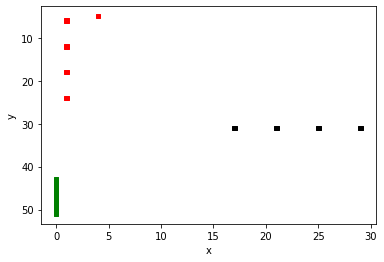

In [103]:
# ax = plt.subplots()

tx_coord_frame.plot.scatter(
    x="x", y="y", c=tx_coord_frame["cluster"].map(cluster_colors), marker="s"
)

# ax.legend()
# plt.legend()

plt.ylim(max(plt.ylim()), min(plt.ylim()))

In this case, there is a large dense cluster in column 0, row numbers in the 40s

#### Treatments acknowledged by the Sample Meatadata Template

In [104]:
template_treatments = get_data_from_extended_cluster_coords(
    template_menu_terms, tx_coord_frame, tx_largest_index, additional_columns=3
)

template_treatments

,0,1,2,3
43,treatment,treatment-chemical administration/addition,chem_administration,{termLabel} {[termID]}; {timestamp}
44,treatment,treatment- watering regimen/schedule,watering_regm,{float} {unit};{Rn/start_time/end_time/duration}
45,treatment,treatment-air temperature regimen,air_temp_regm,{float} {unit};{Rn/start_time/end_time/duration}
46,treatment,treatment-gas evironment/exposure,gaseous_environment,{text};{float} {unit};{Rn/start_time/end_time/...
47,treatment,treatment-isotope exposure/addition,isotope_exposure,{text}
48,treatment,treatment-climate environment,climate_environment,{text};{Rn/start_time/end_time/duration}
49,treatment,treatment-humidity regimen/adition,humidity_regm,{float} {unit};{Rn/start_time/end_time/duration}
50,treatment,treatment-light regimen,light_regm,{text};{float} {unit};{float} {unit}
51,treatment,treatment-biotic regimen/addition,biotic_regm,{text}


#### Are there any treatments in the template that aren't defined by MIxS ?

In [105]:
set(template_treatments[2]) - set(mixs_slots)

{'isotope_exposure'}

In [106]:
tx_melt = pivot_multi_columns("treatment")
tx_renamed = rename_melted_multi(tx_melt)
tx_renamed

value_y,air_temp_regm,chem_administration,isotope_exposure,watering_regm,id
0,NaN,1000µg of C (glucose)/g soil,NaN,75% water holding capacity; moisture maintaine...,UUID:472894-473947-847396
1,35C,NaN,NaN,NaN,UUID:516394-970067-847398
2,NaN,1000µg of C (glucose)/g soil,13C Glucose,NaN,UUID:684267-410686-971057


In [107]:
treatment_row_list = tx_renamed.to_dict("records")
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, treatment_row_list)

----

In [108]:
template_env_met_frame = pd.read_excel(
    template_file, sheet_name="EnvironmentalMetadata"
)
# template_env_met_frame

In [109]:
template_env_met_headers_cols = pd.Series(template_env_met_frame.columns)

firstbad = template_env_met_headers_cols.str.contains("Unnamed|#N/A").idxmax()

goodcols = list(template_env_met_headers_cols[0:firstbad])

In [110]:
template_env_met_headers = template_env_met_frame.loc[0 : (header_rows - 3), goodcols]
template_env_met_headers

,unique_ID,lab_ID,oxy_stat_samp,cur_land_use,drainage_class,fao_class,biotic_relationship,profile_position,horizon,tillage,...,slope_gradient,slope_aspect,link_addit_analys,extreme_salinity,salinity_meth,heavy_metals,heavy_metals_meth,al_sat,al_sat_meth,misc_param
0,"Universally unique ID (ex: IGSN, UUID)",Laboratory ID,oxygen sample status,current land use,drainage classification,soil_taxonomic/FAO classification,biotic relationship,profile position,horizon,history/tillage,...,slope gradient,slope aspect,links to additional analysis,extreme_unusual_properties/salinity,extreme_unusual_properties/salinity method,extreme_unusual_properties/heavy metals,extreme_unusual_properties/heavy metals method,extreme_unusual_properties/Al saturation,extreme_unusual_properties/Al saturation method,miscellaneous parameter
1,{text},{text},"controlled term, see readme","controlled term, see readme","controlled term, see readme","controlled term, see readme","controlled term, see readme","controlled term, see readme","controlled term, see readme","controlled term, see readme",...,{float} {unit},{float} {unit},{PMID}|{DOI}|{URL},{float} {unit},{PMID}|{DOI}|{URL},{text};{float} {unit},{PMID}|{DOI}|{URL},{float} {unit},{PMID}|{DOI}|{URL},{text};{float} {unit}


In [111]:
template_env_met_content = template_env_met_frame.loc[2:, goodcols]
template_env_met_content

,unique_ID,lab_ID,oxy_stat_samp,cur_land_use,drainage_class,fao_class,biotic_relationship,profile_position,horizon,tillage,...,slope_gradient,slope_aspect,link_addit_analys,extreme_salinity,salinity_meth,heavy_metals,heavy_metals_meth,al_sat,al_sat_meth,misc_param
2,UUID:472894-473947-847398,P4_-0-10_4C,aerobic,Horticultural Plants (e.g. tulips),Moderately Well,Andosols,free living,NaN,B Horizon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UUID:684267-410686-971057,L10_-20-30_13C-Gluc,aerobic,Horticultural Plants (e.g. tulips),Moderately Well,Andosols,free living,NaN,B Horizon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UUID:472894-473947-847396,6_J2_75-WHC,aerobic,Horticultural Plants (e.g. tulips),Moderately Well,Andosols,free living,NaN,B Horizon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,UUID:516394-970067-847398,T4-35,aerobic,Horticultural Plants (e.g. tulips),Moderately Well,Andosols,free living,NaN,O Horizon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,UUID:472894-473947-642384,2020-05-21_S19,aerobic,Horticultural Plants (e.g. tulips),Moderately Well,Andosols,free living,NaN,O Horizon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In some of the parsing, I have been mapping "bad" columns names inside of a list comprehension. Here I'm renaming the table because mapping isn't require. A plain `to_dict("records")` is sufficient. SO column renaming will be required.

In [112]:
template_env_met_mapping = {"unique_ID": "id", "lab_ID": "name"}
template_env_met_content = template_env_met_content.rename(
    columns=template_env_met_mapping
)
template_env_met_headers = template_env_met_headers.rename(
    columns=template_env_met_mapping
)

May not actually have to make any use of `template_env_met_headers`

In [113]:
template_env_met_row_list = template_env_met_content.to_dict("records")
cumulative_json_merge = merge_j_on_id(cumulative_json_merge, template_env_met_row_list)

----

# Interim reshaped study data

Not complete, encoded or validated 

In [114]:
proj_nmdc = remove_nans_from_dict(proj_nmdc)
# pprint(proj_nmdc)

In [115]:
proj_json = json.dumps(proj_nmdc, indent=4, sort_keys=False, default=str)
print(proj_json)

{
    "id": "GOLD:Gs01971387",
    "title": "\"Soil microbial response to elevated temperatures and increased carbon availability\"",
    "description": "Northern latitude peatlands contain large reserves of soil carbon (C) due in part to climatic constraints on decomposition, including low temperatures and water inundated soils.... As expected, the two LMWCC substrate additions increased C respiration....",
    "principal_investigator": {
        "has raw value": "Montana Smith",
        "orcid": "0000-0002-8683-0050",
        "email": "montana.smith@pnnl.gov"
    },
    "type": "Study",
    "websites": [
        "https://microbiomedata.org/",
        "https://github.com/microbiomedata"
    ],
    "publications": [
        "https://doi.org/10.1016/j.soilbio.2019.107561",
        "Keiser, Ashley D., et al. \"Peatland microbial community response to altered climate tempered by nutrient availability.\" Soil Biology and Biochemistry 137 (2019): 107561."
    ],
    "doi": {
        "has ra

# Interim reshaped sample data

Not complete, encoded or validated 

In [116]:
cumulative_json_merge_json = json.dumps(
    cumulative_json_merge, indent=4, sort_keys=False, default=str
)

print(cumulative_json_merge_json)

[
    {
        "id": "UUID:472894-473947-847398",
        "name": "P4_-0-10_4C",
        "env_package": "soil",
        "investigation_type": "genome|metabolome",
        "type": "Biosample",
        "part_of": "d787487292564776a968fb4efb1002b5",
        "growth_facil": "field",
        "geo_loc_name": "USA; Prosser, Washington; Washington State University-Irrigated Agriculture Research and Extension Center",
        "samp_mat_process": "snap freeze in liquid N",
        "store_cond": "fresh",
        "samp_store_temp": "4 degree Celsius",
        "env_broad_scale": "arid biome",
        "env_local_scale": "agricultural field",
        "env_medium": "agricultural soil",
        "lat_lon": "46.251709, -119.728663",
        "gold_path_field": "5424:Environmental:Terrestrial:Soil:Bulk soil:Agricultural land",
        "collection_date": "2020-05-21T12:00:00",
        "ncbi_taxonomy_name": "soil metagenome",
        "depth": {
            "has_raw_value": "0-1",
            "has_unit": "m"